In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import networkx.generators as gen
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import networkx as nx
from sklearn.cluster import KMeans
from sklearn import metrics
from networkx.algorithms.community import greedy_modularity_communities
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
filename = 'football.gml'
G_data = nx.read_gml(filename)
B_data = nx.modularity_matrix(G_data)

In [3]:
# Train test split here batch size=train_ds
def givetrain(inputs,targets):  
  train_ds = TensorDataset(inputs, targets)
  train_dl=DataLoader(train_ds,batch_size=len(train_ds))
  return train_dl

In [4]:
# Test The data
print(B_data.shape,len(G_data.edges()))

(115, 115) 613


In [5]:
class AE(nn.Module):
    def __init__(self,in_layers,hidden_layers):
        super().__init__()
        # Encoder
        self.encoder_hidden_layer = nn.Linear(
            in_features=in_layers, out_features=hidden_layers
        )
        self.encoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        # DEcoder
        self.decoder_hidden_layer= nn.Linear(
            in_features=hidden_layers, out_features=hidden_layers
        )
        self.decoder_output_layer = nn.Linear(
            in_features=hidden_layers, out_features=in_layers
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        code = self.encoder_output_layer(activation)
        code = torch.tanh(code)
        # code = nn.Dropout(p=0.01)(code)
        encoder=code
        activation = self.decoder_hidden_layer(code)
        activation = torch.tanh(activation)
        # activation = nn.Dropout(p=0.01)(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.tanh(activation)
        # reconstructed = nn.Dropout(p=0.01)(reconstructed)
        return encoder,reconstructed

In [6]:
epochs = 1000
learning_rate = 1e-3

In [7]:
#  use gpu if available
device = torch.device("cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model1 = AE(hidden_layers=64,in_layers=B_data.shape[0]).to(device)
model2=AE(hidden_layers=32,in_layers=64).to(device)
model3=AE(hidden_layers=16,in_layers=32).to(device)
# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)

# mean-squared error loss
def loss_func(input,target):
  return F.mse_loss(input,target)
print(model2)

AE(
  (encoder_hidden_layer): Linear(in_features=64, out_features=32, bias=True)
  (encoder_output_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_hidden_layer): Linear(in_features=32, out_features=32, bias=True)
  (decoder_output_layer): Linear(in_features=32, out_features=64, bias=True)
)


In [8]:
def train_model(epochs,train_dl,model,optimizer,fl=0):
  enc,out=0,0
  hist=[]
  for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_dl:
      # reset the gradients back to zero
      # PyTorch accumulates gradients on subsequent backward passes
        # optimizer.zero_grad()
        optimizer.zero_grad()
        # compute reconstructions
        encoder,outputs = model(batch_features.float())
        # out=outputs
        if(fl==1):
          outputs=outputs.double()
        # compute training reconstruction loss
        train_loss = loss_func(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        enc=encoder
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        
        # enc=encoder  
    # compute the epoch training loss
    loss = loss / len(train_dl)
    hist.append(loss)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))
  return(enc,hist)

In [9]:
B_data=np.asarray(B_data,dtype=np.float64)
inputs=torch.from_numpy(B_data)
targets=torch.from_numpy(B_data)

train_dl=givetrain(inputs,targets)

# AE 1 training
encoder,hist1=train_model(400,train_dl,model1,optimizer1,fl=1)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 2 training
encoder,hist2=train_model(300,train_dl,model2,optimizer2)
train_dl=givetrain(encoder.detach(),encoder.detach())
print(encoder.detach().shape)

# AE 3 training
encoder,hist3=train_model(200,train_dl,model3,optimizer3)
train_dl=givetrain(encoder.detach(),encoder.detach())
# print(encoder)
print(encoder.detach().shape)

epoch : 1/400, recon loss = 0.09311881
epoch : 2/400, recon loss = 0.09100211
epoch : 3/400, recon loss = 0.08909697
epoch : 4/400, recon loss = 0.08736630
epoch : 5/400, recon loss = 0.08577732
epoch : 6/400, recon loss = 0.08430036
epoch : 7/400, recon loss = 0.08290878
epoch : 8/400, recon loss = 0.08157923
epoch : 9/400, recon loss = 0.08029165
epoch : 10/400, recon loss = 0.07902920
epoch : 11/400, recon loss = 0.07777804
epoch : 12/400, recon loss = 0.07652708
epoch : 13/400, recon loss = 0.07526781
epoch : 14/400, recon loss = 0.07399412
epoch : 15/400, recon loss = 0.07270230
epoch : 16/400, recon loss = 0.07139103
epoch : 17/400, recon loss = 0.07006144
epoch : 18/400, recon loss = 0.06871714
epoch : 19/400, recon loss = 0.06736411
epoch : 20/400, recon loss = 0.06601048
epoch : 21/400, recon loss = 0.06466594
epoch : 22/400, recon loss = 0.06334094
epoch : 23/400, recon loss = 0.06204552
epoch : 24/400, recon loss = 0.06078800
epoch : 25/400, recon loss = 0.05957394
epoch : 2

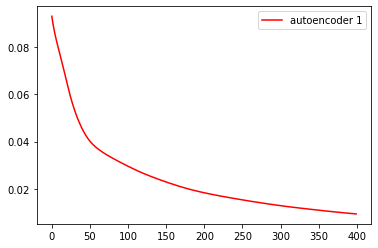

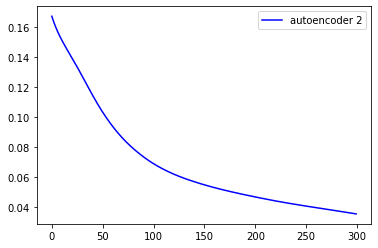

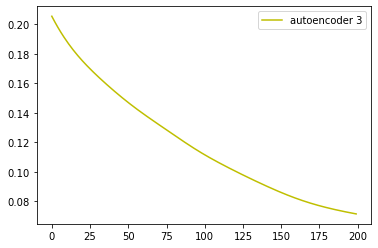

In [11]:
plt.plot(hist1,label='autoencoder 1',color='r')
plt.legend()
plt.show()
plt.plot(hist2,label='autoencoder 2',color='b')
plt.legend()
plt.show()
plt.plot(hist3,label='autoencoder 3',color='y')
plt.legend()
plt.show()

In [12]:
B_data_X=encoder.detach().numpy()

In [16]:
kmeans = KMeans(n_clusters=12,init='k-means++',random_state=1295)
kmeans.fit(B_data_X)
X_ae = kmeans.labels_
#---------------------------------------------------------|Ground Truth|-------
c_attributes = nx.get_node_attributes(G_data,'value')
c_groups = []

for i, val in enumerate(c_attributes.values()):
    c_groups.append(val)     
X_gt = np.array(c_groups)
print(X_ae)
print(X_gt)
metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')

[11  3  1  6 11  6  1  5  5 11  6  2  0  1  0  1 11  4  0  7  4  5  5 11
  8  3  0  4  8  7  7  0  1  3  0  7  0  3  0  1  6 11  0  0  9  3 10  1
  9 10  8  5  6 10  0  7  4  9  2  2  1  0  4  2  1  4  9 10  5  8  4  0
  6 10  6  9  4  5  5  7  7  6  7 10  6  0  9  4 10  3  8  9  9 11  7  4
  4  2  6  0  1  7  6  3 11  3  1  6  5  3 10  5  9  4 10]
[ 7  0  2  3  7  3  2  8  8  7  3 10  6  2  6  2  7  9  6  1  9  8  8  7
 10  0  6  9 11  1  1  6  2  0  6  1  5  0  6  2  3  7  5  6  4  0 11  2
  4 11 10  8  3 11  6  1  9  4 11 10  2  6  9 10  2  9  4 11  8 10  9  6
  3 11  3  4  9  8  8  1  5  3  5 11  3  6  4  9 11  0  5  4  4  7  1  9
  9 10  3  6  2  1  3  0  7  0  2  3  8  0  4  8  4  9 11]


0.9272628615575594

In [15]:
max=0
index_max=0
for value in range(0,2000):
    kmeans = KMeans(n_clusters=12,random_state=value,init='k-means++')
    kmeans.fit(B_data_X)
    X_ae = kmeans.labels_
    #---------------------------------------------------------|Ground Truth|-------
    c_attributes = nx.get_node_attributes(G_data,'value')
    c_groups = []

    for i, val in enumerate(c_attributes.values()):
        c_groups.append(val)      
   
    X_gt = np.array(c_groups)
    temp=metrics.normalized_mutual_info_score(X_gt, X_ae, average_method='arithmetic')
    if(temp>max):
        max=temp
        index_max=value
    if(value%100==0):
        print(index_max,max)
print("Final result:",index_max,max)

0 0.8873885903620813
24 0.9169571911234266
166 0.9248993884606711
166 0.9248993884606711
166 0.9248993884606711
420 0.9272628615575593
420 0.9272628615575593
420 0.9272628615575593
420 0.9272628615575593
420 0.9272628615575593
420 0.9272628615575593
420 0.9272628615575593
420 0.9272628615575593
1295 0.9272628615575594
1295 0.9272628615575594
1295 0.9272628615575594
1295 0.9272628615575594
1295 0.9272628615575594
1295 0.9272628615575594
1295 0.9272628615575594
Final result: 1295 0.9272628615575594


In [24]:
G=G_data
kmeans = KMeans(init='k-means++',n_clusters=12,random_state=index_max)
kmeans.fit(B_data_X)
X_ae = kmeans.labels_
labels_dict={}
for index,item in enumerate(X_ae):
    labels_dict[item]=[]
for index,item in enumerate(X_ae):
    labels_dict[item].append(list(G.nodes)[index])
print(labels_dict)

{11: ['BrighamYoung', 'NewMexico', 'SanDiegoState', 'Wyoming', 'Utah', 'ColoradoState', 'AirForce', 'NevadaLasVegas'], 3: ['FloridaState', 'NorthCarolinaState', 'Virginia', 'GeorgiaTech', 'Duke', 'NorthCarolina', 'Clemson', 'WakeForest', 'Maryland'], 1: ['Iowa', 'PennState', 'Northwestern', 'Wisconsin', 'Michigan', 'Purdue', 'OhioState', 'Minnesota', 'Illinois', 'MichiganState', 'Indiana'], 6: ['KansasState', 'TexasTech', 'Baylor', 'Colorado', 'Kansas', 'IowaState', 'Nebraska', 'TexasA&M', 'Oklahoma', 'Texas', 'Missouri', 'OklahomaState'], 5: ['SouthernCalifornia', 'ArizonaState', 'UCLA', 'Arizona', 'Washington', 'Oregon', 'Stanford', 'WashingtonState', 'OregonState', 'California'], 2: ['NorthTexas', 'LouisianaTech', 'LouisianaMonroe', 'MiddleTennesseeState', 'LouisianaLafayette'], 0: ['NorthernIllinois', 'WesternMichigan', 'Akron', 'BallState', 'BowlingGreenState', 'Buffalo', 'CentralFlorida', 'CentralMichigan', 'Connecticut', 'EasternMichigan', 'Kent', 'MiamiOhio', 'Ohio', 'Toledo', 

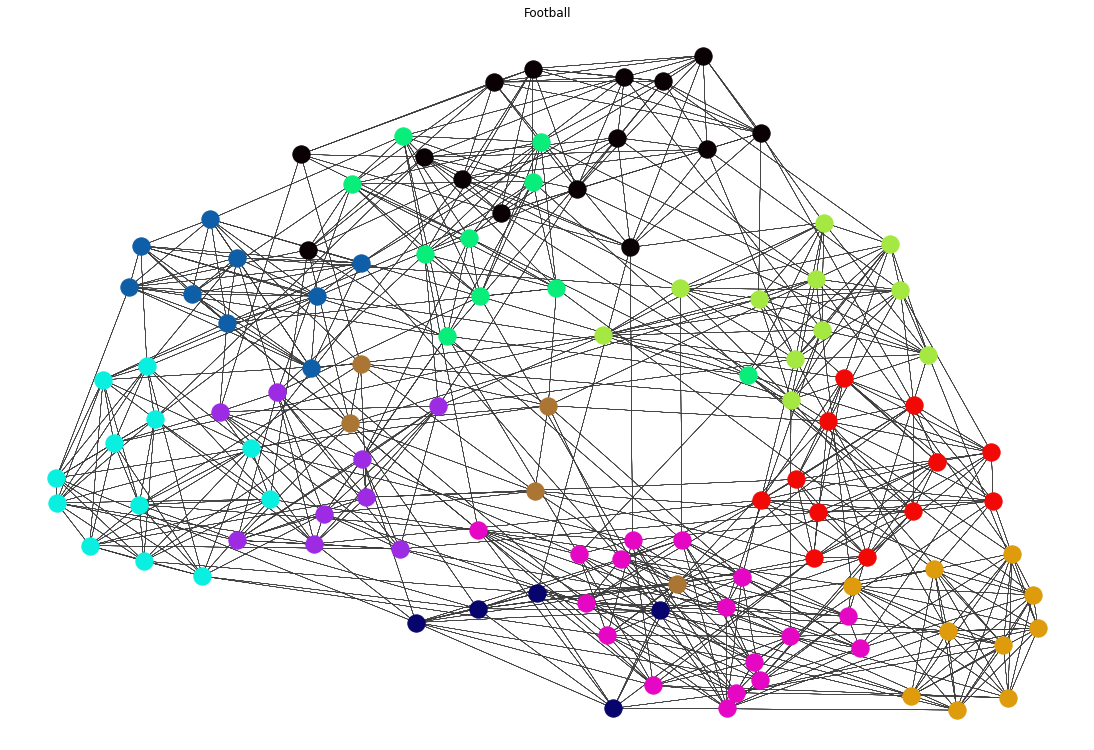

In [45]:
G=G_data
pos=nx.spring_layout(G)
colors=['#f20905','#ab7533','#de9c0d','#a5e841','#09ed7b','#0af0e0','#0f5ea8','#08046e','#9c2be3','#e607c4','#e607c4','#0a0105']
fig= plt.figure(figsize=(15,10))
for key,col in enumerate(labels_dict):
    nx.draw(G,pos,nodelist=labels_dict[key],node_color=colors[col],edge_color='#3b3b3b',node_size=300,width=0.2)

plt.title('Football')
plt.show()